In [2]:
# install.packages("remotes")
remotes::install_github("Thell/RcppMP")


── R CMD build ─────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/RtmpNFFAMN/remotes95f842988ba/Thell-RcppMP-eaf57ae/DESCRIPTION’ (448ms)
─  preparing ‘RcppMP’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘RcppMP_0.1.1.tar.gz’
   


Warning message in i.p(...):
“installation of package ‘/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T//RtmpNFFAMN/file95f842cf6d78/RcppMP_0.1.1.tar.gz’ had non-zero exit status”


In [10]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")
library(tidyverse)

In [8]:
library(devtools)
# load_all("./", reset=TRUE)
load_all("./")

ℹ Loading ptdalgorithms


In [9]:
# #remove.packages("ptdalgorithms")
# #devtools::install_github("kaspermunch/PtDAlgorithms")
# devtools::install_local('../../PtDAlgorithms', quiet=FALSE)

library(ptdalgorithms)

In [58]:
source("./utils/plotting.R")

theme_set(theme_bw())
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

In [30]:
standard_coalescent <- function(n, size, graph=NULL, edge_trans=NULL, epoque=0) {

    state_vector_length <- n + 1

    if (is.null(graph)) {
    
        graph <- create_graph(state_vector_length)
        starting_vertex <- vertex_at(graph, 1)
        initial_state <- c(rep(0, n), epoque)
        initial_state[1] <- n
        
        add_edge(
          starting_vertex,
          create_vertex(graph, initial_state),
          1
        )
        index <- 2
        
    } else {
        nr_states <- vertices_length(graph)
        for (i in 2:(nr_states-1)) {
            if (is.nan(edge_trans[i-1])) {
                next;
            }
            vertex <- vertex_at(graph, i)
            state <- vertex$state
            sister_state <- state
            sister_state[length(sister_state)] <- epoque
            add_edge(
              vertex,
              find_or_create_vertex(graph, sister_state),
              edge_trans[i-1], c(edge_trans[i-1]) # -1 becuase first index is 2 and first element of edge_trans is 1
            )
        }
        index <- nr_states + 1
    }

    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

        # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state

          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next; # an absorbing state that is not the last state
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }

          rate = rate / size
            
          # copy state
          child_state <- state
            
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
        
      index <- index + 1
    }
    if (epoque == 0) {
        return(graph)
    }
}

add_epoque <- function(n, size, graph, epoque_trans, epoque)
    return(standard_coalescent(n, size, graph, epoque_trans, epoque))

In [46]:
n_samples <- 2

In [57]:
graph <- standard_coalescent(n_samples, 1)
graph_as_matrix(graph)

$states
     [,1] [,2] [,3]
[1,]    2    0    0

$SIM
     [,1]
[1,]   -1

$IPV
[1] 1

$indices
[1] 2

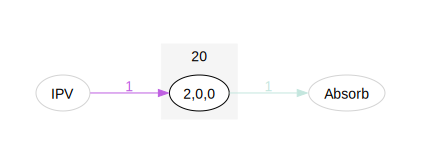

In [49]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

In [ ]:
stop_probability(graph, 1)
accumulated_visiting_time(graph, 1)

In [50]:
x <- stop_probability(graph, 1)
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, 1)
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time

add_epoque(n_samples, 5, graph, epoque_trans_rates, 1)
graph_as_matrix(graph)

$states
     [,1] [,2] [,3]
[1,]    2    0    0
[2,]    2    0    1

$SIM
          [,1]      [,2]
[1,] -1.581197  0.581197
[2,]  0.000000 -0.200000

$IPV
[1] 1 0

$indices
[1] 2 4

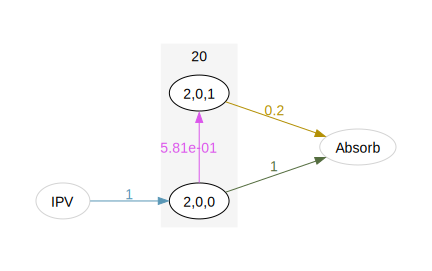

In [51]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

In [52]:
stop_probability(graph, 1)
accumulated_visiting_time(graph, 1)

[1] 0.0000000 0.2054774 0.0000000 0.2580455 0.0000000

[1] 0.0000000 0.5026824 0.0000000 0.1702287 0.0000000

In [53]:
x <- stop_probability(graph, 1)
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, 1)
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time

add_epoque(n_samples, 10, graph, epoque_trans_rates, 2)
graph_as_matrix(graph)

2,0,0
2,0,1
2,0,2
-1.989959,0.581197,0.408762
0.000000,-1.715875,1.515875
0.000000,0.000000,-0.100000


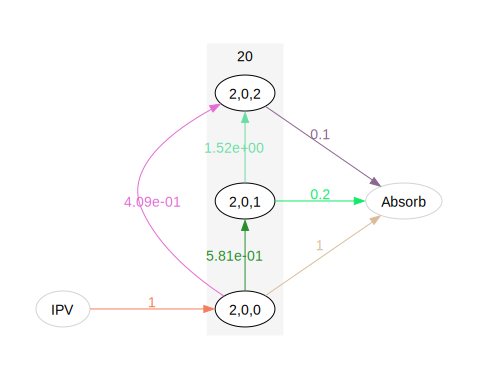

In [54]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

In [55]:
stop_probability(graph, 1)
accumulated_visiting_time(graph, 1)

[1] 0.00000000 0.13643662 0.00000000 0.09141738 0.00000000 0.30210207 0.00000000

[1] 0.00000000 0.43409362 0.00000000 0.09380186 0.00000000 0.17370525 0.00000000